In [301]:
import pymysql
from functools import partial
import requests
import networkx as nx
import freeman as fm
from config import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def run_db_query(connection, query, args=None):
    with connection.cursor() as cursor:
        print('Executando query:')
        cursor.execute(query, args)
        for result in cursor:
            print(result)

connection = pymysql.connect(
    host=myhost,
    user=myuser,
    password=mypass,
    database='twitch')

db = partial(run_db_query, connection)

In [302]:
db("select * from game")

Executando query:
('League of Legends', 21779)
('Counter-Strike: Global Offensive', 32399)
('Just Chatting', 509658)
('Teamfight Tactics', 513143)


In [271]:
def get_games(conn):
    with conn.cursor() as cursor:
        cursor.execute(
            'SELECT * FROM game')
        res = cursor.fetchall()
        if res:
            return res
        else:
            return None
        
def get_links(conn):
    with conn.cursor() as cursor:
        cursor.execute(
            'SELECT * FROM links')
        res = cursor.fetchall()
        if res:
            return res
        else:
            return None

def get_links_from_game(conn,game):
    with conn.cursor() as cursor:
        cursor.execute(
            'SELECT * FROM links WHERE links_game_name = %s',(game))
        res = cursor.fetchall()
        if res:
            return res
        else:
            return None
        
        
# def get_username_from_link(conn,game):
#     with conn.cursor() as cursor:
#         cursor.execute(
#             '''SELECT streamer_display_name FROM streamer
#             INNER JOIN on 
#             WHERE streamer_id = %s''',(game))
#         res = cursor.fetchall()
#         if res:
#             return res
#         else:
#             return None
        
def get_username_from_id(conn,_id):
    with conn.cursor() as cursor:
        cursor.execute(
            'SELECT streamer_display_name FROM streamer WHERE streamer_id = %s',(_id))
        res = cursor.fetchone()
        if res:
            return res
        else:
            return None
        
def get_streamer_id_from_game(conn,game_id):
    with conn.cursor() as cursor:
        cursor.execute(
            'SELECT stream_user_id FROM twitch.stream WHERE stream_game_id = %s GROUP BY stream_user_id ;',(game_id))
        res = cursor.fetchall()
        if res:
            return res
        else:
            return None
        
def get_streams_from_game(conn,time1,time2,game):
    with conn.cursor() as cursor:
        cursor.execute(
            'SELECT * FROM stream WHERE stream_game_id = %s AND stream_request_time BETWEEN %s AND %s',(game, time1, time2))
        res = cursor.fetchall()
        if res:
            return res
        else:
            return None

def get_time(conn,time_1,time_2,game_id):
    #print(time_1,time_2,game_id)
    r = get_streams_from_game(conn,time_1,time_2,game_id)
    #print(r)
    sizes = {}
    if r:
        for node in r:
            sizes[node[2]] = node[6]
    return sizes

def get_progression(conn,start_date,end_date,game_id):
    lista = []
    data = start_date
    while(data < end_date):
        lista.append(get_time(conn,str(data),str(data+timedelta(minutes=10)),game_id))
        data += timedelta(minutes=30)
    return lista

In [80]:
#print(get_username_from_id(connection,str(14293484)))
#print(get_username_from_id(connection,str(44880944)))


time1 = '2019-11-11 17:00:00'
time2 = '2019-11-11 17:10:00'
game = '21779' # LOL

streams_lol = get_streams_from_game(connection,time1,time2,game)
print(len(streams_lol))
for a in streams_lol:
    print(a[1],a[2],a[8]) # _user_id e _user_name

50
52650914 PG_Esports 2019-11-11 17:00:07
85463072 RandomBruceTV 2019-11-11 17:00:08
174955366 Solary 2019-11-11 17:00:03
123020035 Corobizar 2019-11-11 17:00:04
151874024 rhobalas_lol 2019-11-11 17:00:07
48919437 kev1nTV 2019-11-11 17:00:06
74101321 AdcShiiro 2019-11-11 17:00:09
41372534 Broeki1 2019-11-11 17:00:06
82388424 pankylol 2019-11-11 17:00:03
85397463 NoWay4u_Sir 2019-11-11 17:00:02
71852533 OgamingLoL 2019-11-11 17:00:05
70818237 AzunyanOzge 2019-11-11 17:00:04
243834590 Opat04 2019-11-11 17:00:05
31582993 yznb 2019-11-11 17:00:07
38064706 FabulousN 2019-11-11 17:00:06
30357893 Werlyb 2019-11-11 17:00:05
81152719 RezoneGAMES 2019-11-11 17:00:06
46595619 ThaldrinLol 2019-11-11 17:00:07
139358003 OnlyGerier 2019-11-11 17:00:08
66996733 AdamKissAK 2019-11-11 17:00:09
44206377 PanunuLoL 2019-11-11 17:00:07
113164795 루시아 2019-11-11 17:00:06
103861159 얍얍 2019-11-11 17:00:02
125973453 하로맨 2019-11-11 17:00:08
39152815 ClovaoBengala 2019-11-11 17:00:07
48731544 인간젤리 2019-11-11 17:0

In [81]:
print(len(streams_lol))

50


In [144]:


def get_links_user(conn,from_id):
    with conn.cursor() as cursor:
        cursor.execute(
            'SELECT * FROM links WHERE from_id = %s',(from_id))
        res = cursor.fetchall()
        if res:
            return res
        else:
            return None

def make_time_graph(conn,time_1,time_2,game_id):
    r = get_streams_from_game(conn,time_1,time_2,game_id)
    sizes = {}
    print(len(r))
    #get_streams_from_game(connection,time1,time2,game)
    gt = fm.Graph(nx.DiGraph()) # grafo temporario
    for node in r:
        gt.add_node(node[2])
        sizes[node[2]] = node[6]
    for stream in r:
        # print(stream[1],stream[2]) # _user_id e _user_name
        links = get_links_user(connection, stream[1])
        #print(links)
        if links:
            for link in links:
                name1 = stream[2] #get_username_from_id(connection,link[1])[0]
                name2 = get_username_from_id(connection,link[2])[0]
                #gt.add_edges_from([(name1),(name2)])
                if name2 in gt:
                    gt.add_edges_from([(name1, name2)])
            
    return gt, sizes


In [145]:
time1 = '2019-11-11 17:00:00'
time2 = '2019-11-11 17:10:00'
game = '21779' # LOL

g1, sizes1 = make_time_graph(connection,time1,time2,game)
g1.scale_nodes_size(sizes1)
g1.move('kamada_kawai')
g1.label_nodes()
g1.set_all_nodes('labpos', 'hover')
g1.draw()

50


In [148]:
time3 = '2019-11-11 17:30:00'
time4 = '2019-11-11 17:40:00'

g2,sizes2 = make_time_graph(connection,time3,time4,game)
g2.scale_nodes_size(sizes2)
g2.move('kamada_kawai')
g2.label_nodes()
g2.set_all_nodes('labpos', 'hover')
g2.draw()

50


In [149]:
time5 = '2019-11-11 18:00:00'
time6 = '2019-11-11 18:10:00'

g3,sizes3 = make_time_graph(connection,time5,time6,game)
g3.scale_nodes_size(sizes3)
g3.move('kamada_kawai')
g3.label_nodes()
g3.set_all_nodes('labpos', 'hover')
g3.draw()

50


39272


In [150]:
time7 = '2019-11-11 18:30:00'
time8 = '2019-11-11 18:40:00'

g4,sizes4 = make_time_graph(connection,time7,time8,game)
g4.scale_nodes_size(sizes4)
g4.move('kamada_kawai')
g4.label_nodes()
g4.set_all_nodes('labpos', 'hover')
g4.draw()

50


In [151]:
time9 = '2019-11-11 19:00:00'
time10 = '2019-11-11 19:10:00'

g5,sizes5 = make_time_graph(connection,time9,time10,game)
g5.scale_nodes_size(sizes5)
g5.move('kamada_kawai')
g5.label_nodes()
g5.set_all_nodes('labpos', 'hover')
g5.draw()

50


In [152]:
time11 = '2019-11-11 19:30:00'
time12 = '2019-11-11 19:40:00'

g6,sizes6 = make_time_graph(connection,time11,time12,game)
g6.scale_nodes_size(sizes6)
g6.move('kamada_kawai')
g6.label_nodes()
g6.set_all_nodes('labpos', 'hover')
g6.draw()

50


In [179]:
time13 = '2019-11-11 20:00:00'
time14 = '2019-11-11 20:10:00'

g7,sizes7 = make_time_graph(connection,time13,time14,game)
g7.scale_nodes_size(sizes7)
g7.move('kamada_kawai')
g7.label_nodes()
g7.set_all_nodes('labpos', 'hover')
g7.draw()

50


In [180]:
nx.write_gml(g1, "g1.gml")
nx.write_gml(g2, "g2.gml")
nx.write_gml(g3, "g3.gml")
nx.write_gml(g4, "g4.gml")
nx.write_gml(g5, "g5.gml")
nx.write_gml(g6, "g6.gml")
nx.write_gml(g7, "g7.gml")

### Analisando Progressão

In [204]:
sizes_list = [sizes1,sizes2,sizes3,sizes4,sizes5,sizes6, sizes7]


def user_progression(sizes_list,u):
    lis = []
    for s in sizes_list:
        #print('\n>>>>>Time:\n')
        try:
            #print(u,s[u])
            a = s[u]
            lis.append(a)
                
        except:
            #print(u,0)
            #print(len(lis))
            lis.append(0)
            
    return lis


#user_progression(sizes_list,['Faker','TFBlade','Yassuo','hashinshin'])
faker = user_progression(sizes_list,'Faker')
tfblade = user_progression(sizes_list,'TFBlade')
yassuo = user_progression(sizes_list,'Yassuo')
hashi = user_progression(sizes_list,'hashinshin')

2
3
4
5
6
5
6
0
1
2
0


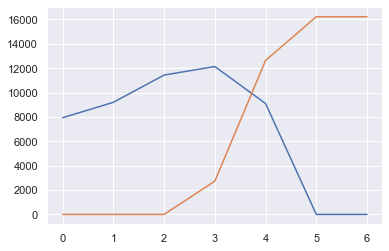

In [188]:
plt.plot(tfblade)
plt.plot(yassuo)
plt.show()

In [193]:
time1 = datetime(2019, 11, 13, 0, 0)
time2 = datetime(2019, 11, 13, 23, 0)

sizes = get_progression(connection,time1,time2,'21779')

2019-11-13 00:00:00 2019-11-13 00:10:00 21779
2019-11-13 00:30:00
2019-11-13 00:30:00 2019-11-13 00:40:00 21779
2019-11-13 01:00:00
2019-11-13 01:00:00 2019-11-13 01:10:00 21779
2019-11-13 01:30:00
2019-11-13 01:30:00 2019-11-13 01:40:00 21779
2019-11-13 02:00:00
2019-11-13 02:00:00 2019-11-13 02:10:00 21779
2019-11-13 02:30:00
2019-11-13 02:30:00 2019-11-13 02:40:00 21779
2019-11-13 03:00:00
2019-11-13 03:00:00 2019-11-13 03:10:00 21779
2019-11-13 03:30:00
2019-11-13 03:30:00 2019-11-13 03:40:00 21779
2019-11-13 04:00:00
2019-11-13 04:00:00 2019-11-13 04:10:00 21779
2019-11-13 04:30:00
2019-11-13 04:30:00 2019-11-13 04:40:00 21779
2019-11-13 05:00:00
2019-11-13 05:00:00 2019-11-13 05:10:00 21779
2019-11-13 05:30:00
2019-11-13 05:30:00 2019-11-13 05:40:00 21779
2019-11-13 06:00:00
2019-11-13 06:00:00 2019-11-13 06:10:00 21779
2019-11-13 06:30:00
2019-11-13 06:30:00 2019-11-13 06:40:00 21779
2019-11-13 07:00:00
2019-11-13 07:00:00 2019-11-13 07:10:00 21779
2019-11-13 07:30:00
2019-11-13

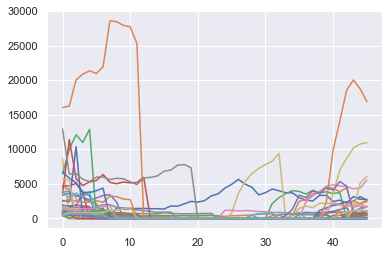

In [243]:
def user_progression(sizes_list,u):
    lis = []
    for s in sizes_list:
        #print('\n>>>>>Time:\n')
        try:
            #print(u,s[u])
            a = s[u]
            lis.append(a)
                
        except:
            #print(u,0)
            lis.append(0)
    return lis


#sizes[0].keys()

for user in sizes[0].keys():
    plt.plot(user_progression(sizes,user),label=user)
plt.show()

0
1
2
3
4
5
6
7
15
16
17
18
19
20
27
28
38
39
40
41
42
43
44
45
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
0
1
2
3
4
5
6
7
8
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


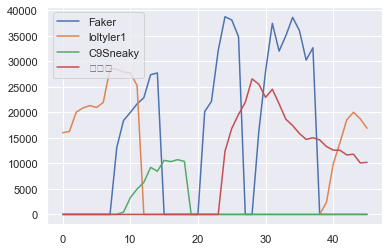

<Figure size 864x864 with 0 Axes>

In [240]:
a = user_progression(sizes,'Faker')
b = user_progression(sizes,'loltyler1')
c = user_progression(sizes,'C9Sneaky')
d = user_progression(sizes,'한동숙')


# ax.plot(a)
# ax.legend(['Faker'])
# ax.plot(b)
# ax.legend(['loltyler1'])
# ax.plot(c)
# ax.legend(['C9Sneaky'])
# ax.plot(d)
# ax.legend(['한동숙'])


plt.plot(a,label='Faker')
plt.plot(b,label='loltyler1')
plt.plot(c,label='C9Sneaky')
plt.plot(d,label='한동숙')
plt.legend(loc='upper left')
plt.figure(figsize=(12,12))
plt.show()

#plt.legend((a, b, c, d), ('Faker', 'loltyler1', 'C9Sneaky','C9Sneaky'))

['loltyler1', 'Faker', 'C9Sneaky', 'Nightblue3', '괴물쥐123', '한동숙']


/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 44340 missing from current font.

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 47932 missing from current font.

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 51536 missing from current font.

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 44340 missing from current font.

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 47932 missing from current font.

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 51536 missing from current font.



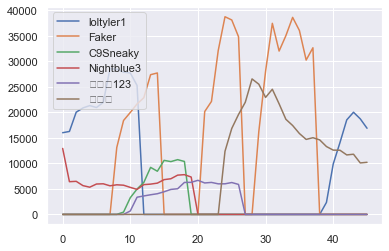

In [245]:
import operator
#max(sizes[38].items(), key=operator.itemgetter(1))
list_top_users = []
for s in sizes:
    a = max(s.items(), key=operator.itemgetter(1))[0]
    if a not in list_top_users:
        list_top_users.append(a)

        
print(list_top_users)
for u in list_top_users:
    plt.plot(user_progression(sizes,u),label=u)
plt.legend(loc='upper left')

In [292]:
def show_top_players(sizes):
    list_top_users = []
    for s in sizes:
        if s:
            a = max(s.items(), key=operator.itemgetter(1))[0]
            if a not in list_top_users:
                list_top_users.append(a)
    print(list_top_users)
    plt.figure(figsize=(12,8))
    for u in list_top_users:
        plt.plot(user_progression(sizes,u),label=u)
        
    
    plt.legend(loc='upper left')

['loltyler1', 'Faker', '씨맥', '接接', 'lol_Khan', 'TFBlade', 'Yassuo']


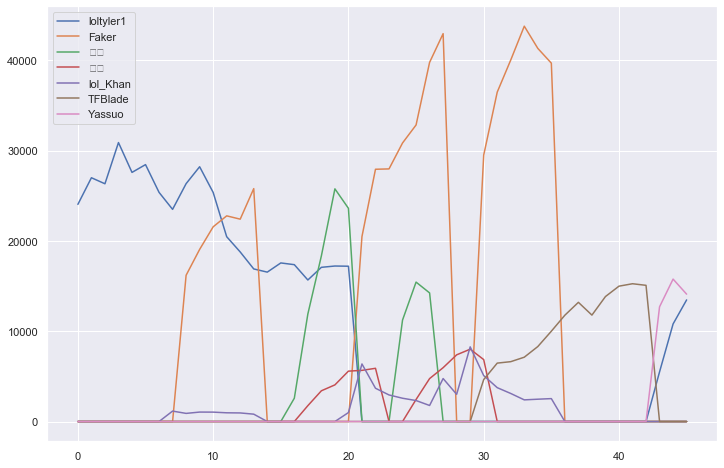

In [280]:
# Dia 12
time1 = datetime(2019, 11, 12, 0, 0)
time2 = datetime(2019, 11, 12, 23, 0)

sizes12 = get_progression(connection,time1,time2,'21779')
show_top_players(sizes12)

['loltyler1', 'Faker', 'C9Sneaky', 'Nightblue3', '괴물쥐123', '한동숙']


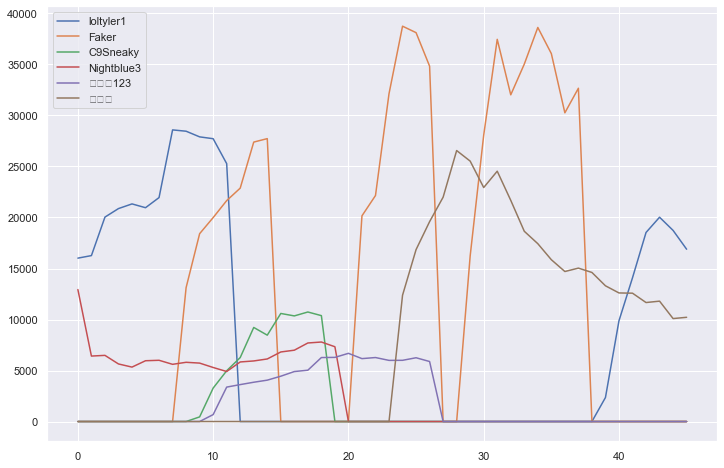

In [281]:
# Dia 13
time1 = datetime(2019, 11, 13, 0, 0)
time2 = datetime(2019, 11, 13, 23, 0)

sizes13 = get_progression(connection,time1,time2,'21779')
show_top_players(sizes13)

['loltyler1', 'C9Sneaky', '앰비션_', '괴물쥐123', '接接', '한동숙', 'TFBlade', 'NoWay4u_Sir', 'Yassuo']


/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 50544 missing from current font.

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 48708 missing from current font.

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 49496 missing from current font.

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 50544 missing from current font.

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 48708 missing from current font.

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 49496 missing from current font.



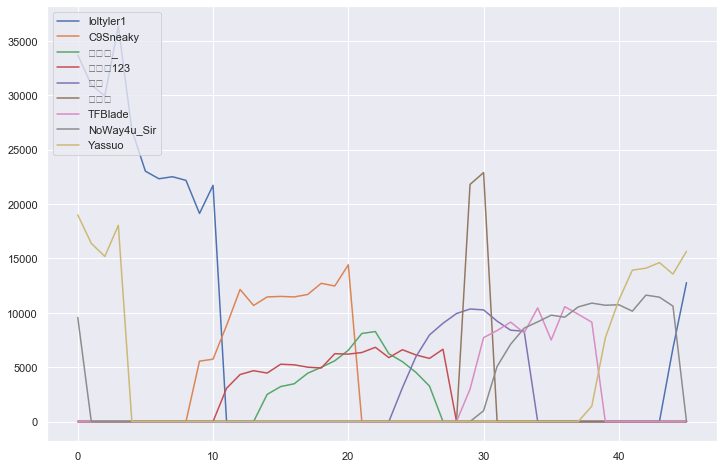

In [283]:
# Dia 14
time1 = datetime(2019, 11, 14, 0, 0)
time2 = datetime(2019, 11, 14, 23, 0)

sizes14 = get_progression(connection,time1,time2,'21779')
show_top_players(sizes14)

['loltyler1', 'Yassuo', 'SaltyTeemo', '한동숙', 'TFBlade', 'Elwind']


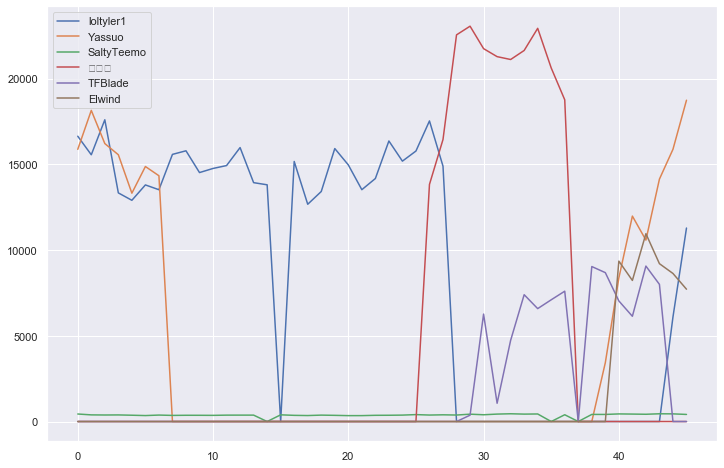

In [293]:
# Dia 15
time1 = datetime(2019, 11, 15, 0, 0)
time2 = datetime(2019, 11, 15, 23, 0)

sizes15 = get_progression(connection,time1,time2,'21779')

#print(sizes15)
show_top_players(sizes15)

['loltyler1', 'Yassuo', 'SaltyTeemo', '한동숙', 'TFBlade', 'Elwind']


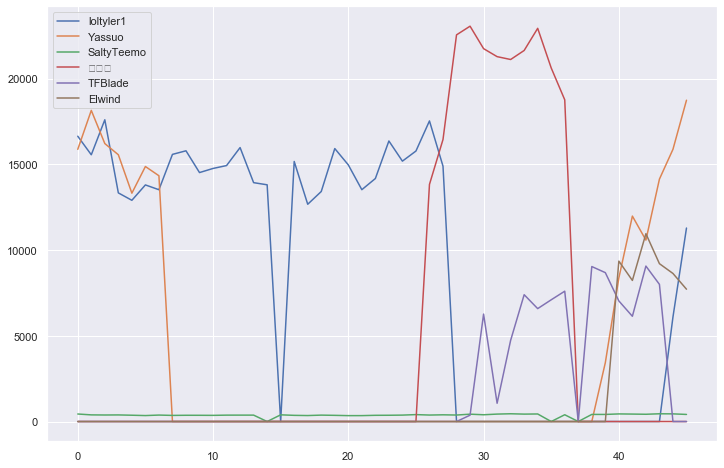

In [303]:
# Dia 15
time1 = datetime(2019, 11, 15, 0, 0)
time2 = datetime(2019, 11, 15, 23, 0)

sizes15 = get_progression(connection,time1,time2,'21779')

#print(sizes15)
show_top_players(sizes15)